# Predicting HDB Resale Prices in Singapore I
## Dataset Preparation

Public housing in Singapore is managed by the Housing and Development Board. The aim of public housing is to provide affordable housing options to Singaporeans despite domestic land constraints. This is achieved through high-rise housing structures and grants that make the costs of housing affordable for the average Singaporean. In the recent years, there have been an increasing number of HDB flats making headlines for record-breaking transaction prices.

In this project, we explore the factors that might affect HDB resale prices in Singapore. Since majority of Singaporeeans own HDB units, this could give them an indication as to the current prices of their property. In this part, we will work on publicly available datasets to generate a set of possible factors that might affect resale prices. In the next part, we will make use of data analytics to examine the effect of housing prices on these factors, and use models to predict the resale prices of HDB flats in Singapore.

---

### Importing Necessary Packages

For this project, we will be using basic packages in Python, such as Numpy and Pandas to import and manipulate existing datasets. We will also be making use of Requests to read APIs.

In [1]:
# Surpressing warnings for readibility

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Importing necessary packages

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

pd.set_option("display.max_columns", None)

---

### HDB Resale Prices Dataset

The dataset that we will be using is from data.gov.sg, a site that publishes a spread of public data in Singapore, from economic indicators to transport, infrastructure, etc. We will be using the Resale Flat Prices published by HDB. While the data for this dataset dates back to 1990s, we will only be using data from 2017 onwards. More recent data would provide a more accurate picture of the updated needs of Singaporeans, and how this reflects in what they are willing to pay for resale flats.

We will be using the data.gov.sg API to extract the dataset, although the dataset can also be downloaded from the website.

In [7]:
# Importing dataset from data.gov.sg API

dataset = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3&limit=108048').json()
resale_df = pd.DataFrame(dataset['result']['records'])

In [21]:
# Checking shape of dataset

rows, cols = resale_df.shape
print('Number of rows: {}'.format(rows))
print('Number of columns : {}'.format(cols))

Number of rows: 108048
Number of columns : 12


In [22]:
# Checking info of dataset

resale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108048 entries, 0 to 108047
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 108048 non-null  object 
 1   flat_type            108048 non-null  object 
 2   flat_model           108048 non-null  object 
 3   floor_area_sqm       108048 non-null  float64
 4   street_name          108048 non-null  object 
 5   resale_price         108048 non-null  float64
 6   month                108048 non-null  object 
 7   remaining_lease      108048 non-null  object 
 8   lease_commence_date  108048 non-null  int64  
 9   storey_range         108048 non-null  object 
 10  _id                  108048 non-null  int64  
 11  block                108048 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 9.9+ MB


From the info of the dataset, we observe that there are no missing values in any of the columns. This would make things easier, as we do not have to take additional steps to treat missing data.

In [23]:
# Examining dataset

resale_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01,61 years 04 months,1979,10 TO 12,1,406
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01,60 years 07 months,1978,01 TO 03,2,108
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01,62 years 05 months,1980,01 TO 03,3,602
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01,62 years 01 month,1980,04 TO 06,4,465
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01,62 years 05 months,1980,01 TO 03,5,601


The existing dataset has 104,282 resale transactions from 2017 to 2021. For each transaction, it also contains basic geographic information such as the block, storey range, street name, and the town of the flat. It also contains additional information such as the flat type and model, floor area, and remaining lease on the flat. We will mainly be using the existing geographic information to generate additional geographic factors.

In particular, we will be generating the following features:
* Distance to nearest MRT/LRT
  * According to the population census, 57.7% of employed residents took a combination of public transport to work. While bus stops are commonly conveniently located in HDB estates, it is more likely that MRT/LRT stations are further away. By considering the distance to the nearest MRT/LRT, we could get a sensing of how convenient that area is.
* Distance to nearest primary and secondary school
  * Another concern especially for parents would probably be the availability of schools in the vacinity. Having schools close to their homes would make it more convenient for their children.
* Distance to nearest shopping mall
  * Shopping centres are commonly places where Singaporeans would buy neccessities from groceries to clothing, as well as have their meals at restraurants or food courts. By considering the distance to the nearest mall, we get a sensing of the availability of such amenities in the area.
  
A limited number of features were considered in this analysis. Further features that can be considered, as well as improvements to existing features will be discussed later.

---

### Geocoding HDB Resale Prices

To enable creation of other distance-based features, we would need to generate the positions of the resale flats. Here, we can make use of the OneMap API, which allows us to search for the address of the flat and return its latitude and longitude.

In [24]:
# Function for searching a single address in OneMap API

def onemap_geocoding(address):
    result = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    result = eval(result.text)
    
    if result['found'] > 0:
        lat, long = result['results'][0]['LATITUDE'], result['results'][0]['LONGITUDE']
        return address, lat, long
    else:
        pass

In [25]:
# Function that takes in a series of addresses, and outputs the corresponding latitude and longitudes.

def geocode_series(addresses):
    coord_list = []
    failed_list = []
    failed = 0
    t = trange(len(addresses), desc='Geoding Addresses')
    for i in t:
        try:
            result = onemap_geocoding(addresses[i])
            if len(result) > 0:
                coord_list.append(result)
                t.set_description('{} failed'.format(failed))
        except:
            failed_list.append(addresses[i])
            failed += 1
            t.set_description('{} failed'.format(failed))
    
    return coord_list

In [26]:
# Creating address field to be used as search parameter.

resale_df['address'] = resale_df['block'] + ' ' + resale_df['street_name']

In [27]:
# As some addresses are duplicated, we retrieve a unique list of addresses to search, so as to reduce runtime.

house_addresses = resale_df['address'].unique()

In [28]:
# Geocoding of addresses. Resultant dataset coord_df is a list of latitudes and longitudes for each unique address.

coord_list = geocode_series(house_addresses)

coord_df = pd.DataFrame(coord_list, columns=['address', 'latitude', 'longitude'])
coord_df[['latitude','longitude']] = coord_df[['latitude', 'longitude']].astype(float)

22 failed: 100%|███████████████████████████| 9123/9123 [14:31<00:00, 10.47it/s]


---

### Issues with Geocoding Addresses

Using this initial approach, we notice a few issues that require addressing.

Firstly, there are a few addresses that did not return any search results. Upon inspection, these addresses are all along "St. George's Rd". After looking up the address on OneMap, I found out that OneMap stores this street name as "Saint George's Road", and is unable to find the address using the short form for "Saint". To address this, the addresses containing "St. George's Rd" were changed to the full form "Saint George's Road".

In [29]:
# Renaming St. George's Rd to Saint George's Rd

resale_df['address'] = resale_df['address'].str.replace('ST. GEORGE', 'SAINT GEORGE')

Secondly, it was later observed that there were a few addresses that returned the wrong latitudes and longitudes. For instance, the address "2 Beach Rd" was mapped to a place in Changi instead of near the Lavender area.

The function created for the geocoding assumed that the top search result is the most accurate one, and returned the latitude and longitude for that result. Upon further investigation, it was found out that that was not always the case, and multiple addressses were mapped to the wrong coordinates. A better alternative would have been to use postal codes, which is unique to each address and would prevent multiple returns. However, since postal codes for the resale flats were not provided, further treatment had to be taken to ensure the correct latitude and longitude were obtained.

In [30]:
# Examining record for 2 Beach Rd

coord_df[coord_df['address'] == '2 BEACH RD']

,address,latitude,longitude
2450,2 BEACH RD,1.304033,103.864928


In [32]:
beachrd = eval(requests.get('https://developers.onemap.sg/commonapi/search?searchVal=2 BEACH RD&returnGeom=Y&getAddrDetails=Y&pageNum=1').text)
for result in beachrd['results']:
    print(result)

{'SEARCHVAL': 'CHANGI BEACH CLUB', 'BLK_NO': '2', 'ROAD_NAME': 'ANDOVER ROAD', 'BUILDING': 'CHANGI BEACH CLUB', 'ADDRESS': '2 ANDOVER ROAD CHANGI BEACH CLUB SINGAPORE 509984', 'POSTAL': '509984', 'X': '43798.8961983481', 'Y': '41376.2409398966', 'LATITUDE': '1.39046224455233', 'LONGITUDE': '103.975283854916', 'LONGTITUDE': '103.975283854916'}
{'SEARCHVAL': 'BEACH ROAD GARDENS', 'BLK_NO': '2', 'ROAD_NAME': 'BEACH ROAD', 'BUILDING': 'BEACH ROAD GARDENS', 'ADDRESS': '2 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190002', 'POSTAL': '190002', 'X': '31517.8850314394', 'Y': '31818.8846020326', 'LATITUDE': '1.30403300585898', 'LONGITUDE': '103.864928408355', 'LONGTITUDE': '103.864928408355'}


To address this, a few steps were taken.
* Since the search results from OneMap returns the block no. and road name, we could reconstruct the address of the search result and compare it to the original address. If the two addresses match, then we would take the latitude and longitude for that result.
* Before doing that, it was observed that the returns were in full form, while the original addresses had short forms (e.g. 'Road' vs 'Rd'). To make comparing the addresses possible, we would first need to convert all the short forms into their respective full forms. This is done by running the comparison function, and examining mismatches to identify the list of short forms present that had to be converted.

In [31]:
# List of short forms converted to long forms

changes = [[r'\bAVE\b', 'AVENUE'],
           [r'\bRD\b', 'ROAD'],
           [r'\bNTH\b', 'NORTH'],
           [r'\bSTH\b', 'SOUTH'],
           [r'\bST\b', 'STREET'],
           [r'\bCTRL\b', 'CENTRAL'],
           [r'\bDR\b', 'DRIVE'],
           [r'\bBT\b', 'BUKIT'],
           [r'\bJLN\b', 'JALAN'],
           [r'\bCRES\b', 'CRESCENT'],
           [r'\bLOR\b', 'LORONG'],
           [r"\bC'WEALTH\b", 'COMMONWEALTH'],
           [r'\bCL\b', 'CLOSE'],
           [r'\bGDNS\b', 'GARDENS'],
           [r'\bUPP\b', 'UPPER'],
           [r'\bHTS\b', 'HEIGHTS'],
           [r'\bTER\b', 'TERRACE'],
           [r'\bPL\b', 'PLACE'],
           [r'\bTG\b', 'TANJONG'],
           [r'\bPK\b', 'PARK'],
           [r'\bMKT\b', 'MARKET'],
           [r'\bKG\b', 'KAMPONG']]

for short, long in changes:
    resale_df['address'] = resale_df['address'].str.replace(short, long)

In [34]:
# Improved function for geocoding addresses by checking block no. and street name

def onemap_geocoding_flat(address):
    result = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    result = eval(result.text)
    
    if result['found'] > 0:
        for i in result['results']:
            lat, long = i['LATITUDE'], i['LONGITUDE']
            r_block, r_street = i['BLK_NO'], i['ROAD_NAME']
            r_add = r_block + ' ' + r_street
            
            if r_add == address:
                return address, r_add, lat, long
            else:
                continue
        return address, 'none', '0', '0'
    else:
        pass
    
def geocode_series_flat(addresses):
    coord_list = []
    failed_list = []
    failed = 0
    t = trange(len(addresses), desc='Geoding Addresses')
    for i in t:
        try:
            result = onemap_geocoding_flat(addresses[i])
            if len(result) > 0:
                coord_list.append(result)
                t.set_description('{} failed'.format(failed))
        except:
            failed_list.append(addresses[i])
            failed += 1
            t.set_description('{} failed'.format(failed))
    print(failed_list if failed_list else "All passed")
    return coord_list

In [35]:
# Second round of geocoding resale flat addresses

house_addresses = resale_df['address'].unique()

coord_list = geocode_series_flat(house_addresses)
coord_df = pd.DataFrame(coord_list, columns = ['address', 'r_address', 'latitude', 'longitude'])

0 failed: 100%|████████████████████████████| 9123/9123 [14:17<00:00, 10.63it/s]

All passed


A final check was done for any addresses that did not match any search results. It was found that two addresses belonging to "Choa Chu Kang Central" did not return any search results. After checking OneMap, these two addresses were collectively grouped under "Blk 216 and 215 Choa Chu Kang Central". Since there is only one such result that required modification, the modification was done manually.

In [36]:
# Checking for addresses with no search results.

coord_df[coord_df['r_address'] == 'none']

,address,r_address,latitude,longitude
1283,216 CHOA CHU KANG CENTRAL,none,0,0
7150,215 CHOA CHU KANG CENTRAL,none,0,0


In [39]:
# Manually correcting the two empty addresses

cck_exception = eval(requests.get('https://developers.onemap.sg/commonapi/search?searchVal=BLK 216 AND 215 CHOA CHU KANG CENTRAL&returnGeom=Y&getAddrDetails=Y&pageNum=1').text)['results'][0]
coord_df.loc[1283]['latitude'], coord_df.loc[1283]['longitude'] = cck_exception['LATITUDE'], cck_exception['LONGITUDE']
coord_df.loc[7150]['latitude'], coord_df.loc[7150]['longitude'] =cck_exception['LATITUDE'], cck_exception['LONGITUDE']

In [38]:
# Checking to ensure changes were adopted.

coord_df.loc[[1283,7150]]

,address,r_address,latitude,longitude
1283,216 CHOA CHU KANG CENTRAL,none,1.38308302434129,103.747076627693
7150,215 CHOA CHU KANG CENTRAL,none,1.38308302434129,103.747076627693


In [40]:
# Merging list of latitudes and longitudes back into the original dataframe. We also drop 'r_address' that was used for verification.

coord_df[['latitude','longitude']] = coord_df[['latitude', 'longitude']].astype(float)
coord_df.drop('r_address', axis=1, inplace=True)

resale_df = resale_df.merge(right=coord_df, on='address', how='left')

---

### Distance to nearest MRT

A list of existing MRT/LRT stations were obtained from LTA's website. A similar process was adopted to geocode the MRT/LRT stations as was done for the resale flats.

Using the latitudes and longitudes of the resale flats and MRT/LRT stations, the distances to each MRT/LRT station was calculated using Pythagoras' Theorem. The distances were compared, and the shortest distance to the nearest MRT station was returned.

In [41]:
# Reading in list of MRT/LRT stations

mrt_df = pd.read_csv('data\mrt_stations.csv')

In [42]:
# Geocoding of MRT/LRT stations.

mrt_names = mrt_df['stn_name'].unique()
mrt_coord = geocode_series(mrt_names)

0 failed: 100%|██████████████████████████████| 170/170 [00:12<00:00, 13.55it/s]


In [51]:
# Function for calculating nearest distance to each flat.

def calculate_dist(address_df, dist_list):
    temp = address_df.copy()
    for i in dist_list:
        name, lat, long = i[0], float(i[1]), float(i[2])
        temp['{}'.format(name)] = (((address_df['latitude'] - lat) * 110.574) ** 2 + ((address_df['longitude'] - long) * 111.32) ** 2) ** 0.5
    nearest_name = temp.drop(['address', 'longitude', 'latitude'], axis=1).idxmin(axis=1)
    nearest_dist = temp.drop(['address', 'longitude', 'latitude'], axis=1).min(axis=1)
    nearest = pd.concat([temp['address'], nearest_name, nearest_dist], axis=1)
    return nearest

In [54]:
# Calculating the nearest MRT/LRT station.

mrt_dist_df = calculate_dist(coord_df, mrt_coord)
mrt_dist_df.columns = ['address', 'nearest_mrt', 'nearest_mrt_dist']

In [55]:
# Resultant dataset mrt_dist_df is a list of the nearest MRT station and their distance to each unique address.

mrt_dist_df.head()

,address,nearest_mrt,nearest_mrt_dist
0,406 ANG MO KIO AVENUE 10,ANG MO KIO MRT STATION,1.000002
1,108 ANG MO KIO AVENUE 4,MAYFLOWER MRT STATION,0.190030
2,602 ANG MO KIO AVENUE 5,LENTOR MRT STATION,0.532151
3,465 ANG MO KIO AVENUE 10,ANG MO KIO MRT STATION,0.945591
4,601 ANG MO KIO AVENUE 5,LENTOR MRT STATION,0.498418


In [94]:
# Merging the list of nearest MRT/LRT stations back into the original dataset

resale_df = resale_df.merge(right=mrt_dist_df, on='address', how='left')

---

### Distance to nearest Primary/Secondary School

A list of existing schools was also obtained from data.gov.sg. Due to the different types of schools, additional treatment had to be used to categorise certain schools (i.e. I-P schools, schools with primary and secondary sections).

Using similar methods, the schools were geocoded and split into Primary and Secondary schools. For each set, the nearest school was found using the same function as before.

In [43]:
# Importing list of schools from data.gov.sg API

schools = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id=ede26d32-01af-4228-b1ed-f05c45a1d8ee&limit=347').json()
schools_df = pd.DataFrame(schools['result']['records'])[['school_name', 'postal_code', 'mainlevel_code']]

In [44]:
# List of schools with 'mainlevel_code' == 'Mixed Levels' was isolated, and recategorised into whether they were I-P schools or schools with primary and secondary sections.

ip_schools = ['ANGLO-CHINESE SCHOOL (INDEPENDENT)',
              'DUNMAN HIGH SCHOOL',
              'HWA CHONG INSTITUTION',
              'NATIONAL JUNIOR COLLEGE',
              'NUS HIGH SCHOOL OF MATHEMATICS AND SCIENCE',
              'RAFFLES INSTITUTION',
              'RIVER VALLEY HIGH SCHOOL',
              'SCHOOL OF THE ARTS, SINGAPORE',
              'SINGAPORE SPORTS SCHOOL',
              "ST. JOSEPH'S INSTITUTION",
              'TEMASEK JUNIOR COLLEGE']
both_schools = ['CATHOLIC HIGH SCHOOL',
                "CHIJ ST. NICHOLAS GIRLS' SCHOOL",
                'MARIS STELLA HIGH SCHOOL']

for school in ip_schools:
    schools_df['mainlevel_code'] = np.where((schools_df['school_name'] == school), 'SECONDARY', schools_df['mainlevel_code'])
    
both_schools_df = schools_df[schools_df['school_name'].isin(both_schools)]
both_schools_df['mainlevel_code'] = 'SECONDARY'

for school in both_schools:
    schools_df['mainlevel_code'] = np.where((schools_df['school_name'] == school), 'PRIMARY', schools_df['mainlevel_code'])
    
schools_df = pd.concat([schools_df, both_schools_df])

In [45]:
# Since we are only considering Primary and Secondary schools, Junior Colleges were dropped from the list.

schools_df.drop(schools_df[schools_df['mainlevel_code'] == 'JUNIOR COLLEGE'].index, inplace=True)
schools_df.drop(schools_df[schools_df['mainlevel_code'] == 'CENTRALISED INSTITUTE'].index, inplace=True)

In [46]:
# Since postal codes for schools were available, they were used for geocoding instead. However before geocoding, it was also noticed that some schools have postal codes with a missing leading '0'.

school_postal = schools_df['postal_code'].unique()
for i in range(len(school_postal)):
    if len(school_postal[i]) < 6:
        print(school_postal[i])

88256
99757
99138
99840


In [47]:
# These codes were addressed before geocoding.

for i in range(len(school_postal)):
    if len(school_postal[i]) < 6:
        new_postal = '0' + school_postal[i]
        school_postal[i] = new_postal

In [48]:
# Geocoding of primary/secondary schools.

school_coord = geocode_series(school_postal)
school_coord_df = pd.DataFrame(school_coord, columns=['postal_code', 'latitude', 'longitude'])
school_coord_df[['latitude', 'longitude']] = school_coord_df[['latitude', 'longitude']].astype(float)
schools_df = schools_df.merge(right=school_coord_df, on='postal_code', how='left')

0 failed: 100%|██████████████████████████████| 333/333 [00:28<00:00, 11.88it/s]


In [63]:
# Schools were then separated into primary and secondary schools, as these two will be treated separately.

schools_pri_df = schools_df[schools_df['mainlevel_code'] == 'PRIMARY'][['school_name', 'latitude', 'longitude']]
schools_pri = list(schools_pri_df.itertuples(index=False, name=None))
schools_sec_df = schools_df[schools_df['mainlevel_code'] == 'SECONDARY'][['school_name', 'latitude', 'longitude']]
schools_sec = list(schools_sec_df.itertuples(index=False, name=None))

In [64]:
# Calculating the nearest primary and secondary school.

schools_pri_dist_df = calculate_dist(coord_df, schools_pri)
schools_pri_dist_df.columns = ['address', 'nearest_pri_sch', 'nearest_pri_sch_dist']

schools_sec_dist_df = calculate_dist(coord_df, schools_sec)
schools_sec_dist_df.columns = ['address', 'nearest_sec_sch', 'nearest_sec_sch_dist']

In [65]:
# Resultant datasets schools_pri_dist_df and schools_sec_dist_df are lists of the nearest primary and secondary schools and their distance to each unique address.

schools_pri_dist_df.head()

,address,nearest_pri_sch,nearest_pri_sch_dist
0,406 ANG MO KIO AVENUE 10,TOWNSVILLE PRIMARY SCHOOL,0.218124
1,108 ANG MO KIO AVENUE 4,ANG MO KIO PRIMARY SCHOOL,0.241601
2,602 ANG MO KIO AVENUE 5,MAYFLOWER PRIMARY SCHOOL,0.506847
3,465 ANG MO KIO AVENUE 10,TECK GHEE PRIMARY SCHOOL,0.691887
4,601 ANG MO KIO AVENUE 5,MAYFLOWER PRIMARY SCHOOL,0.546442


In [95]:
# Merging nearest primary and secondary schools into the original dataset.

resale_df = resale_df.merge(right=schools_pri_dist_df, on='address', how='left')
resale_df = resale_df.merge(right=schools_sec_dist_df, on='address', how='left')

---

### Distance to nearest Mall

A list of exising malls was also obtained, and a similar process of geocoding and calculating the nearest mall was done.

In [49]:
# Importing list of shopping malls in Singapore.

malls_df = pd.read_csv('data\malls.csv')

In [50]:
# Geocoding of shopping malls.

malls_coord = geocode_series(malls_df['mall_name'])

0 failed: 100%|██████████████████████████████| 170/170 [00:13<00:00, 12.22it/s]


In [69]:
# Calculating the nearest shopping mall.

malls_dist_df = calculate_dist(coord_df, malls_coord)
malls_dist_df.columns = ['address', 'nearest_mall', 'nearest_mall_dist']

In [70]:
# Resultant dataset malls_dist_df is a list of the nearest shopping mall and their distance to each unique address.

malls_dist_df.head()

,address,nearest_mall,nearest_mall_dist
0,406 ANG MO KIO AVENUE 10,AMK Hub,1.014089
1,108 ANG MO KIO AVENUE 4,Broadway Plaza,0.869109
2,602 ANG MO KIO AVENUE 5,Broadway Plaza,1.525833
3,465 ANG MO KIO AVENUE 10,myVillage At Serangoon Garden,0.894047
4,601 ANG MO KIO AVENUE 5,Broadway Plaza,1.569570


In [96]:
# Merging nearest shopping mall into the original dataset.

resale_df = resale_df.merge(right=malls_dist_df, on='address', how='left')

---

### Adjusting Resale Prices for Inflation

The data available is across a range of years, we would also have to consider the role of inflation in resale prices. For this particular project, since we are looking at predicting current house prices, we will be adjusting the prices to 2021 Q2. While there are some resale transactions that take place in 2021 Q3, the Consumer Price Index (CPI) data for houseing was not yet available. As such, we assume that there is no change in the CPI between 2021 Q2 and 2021 Q3.

Information for the CPI of resale flats was obtained from the Singapore Department of Statistics. Since the price index is updated every quarter, it was necessary to group the transaction months of the resale flats into quarters before using the price index to adjust prices.

In [17]:
# Importing price index for resale flats.

inflation_df= pd.read_csv('data\housing_cpi.csv')

In [73]:
# Grouping transaction months into quarters.

price_df = resale_df[['month', 'resale_price']]
price_df['quarter'] = pd.to_datetime(price_df['month'].values, format='%Y-%m').astype('period[Q]').astype(str)

In [74]:
# Adjusting prices to 2021 Q2 using price index for resale flats.

price_df = price_df.merge(right=inflation_df, on='quarter', how='left')

price_df['resale_price'] = price_df['resale_price'].astype(float)
price_df['inflation_price'] = price_df['resale_price'] * price_df['inflation']

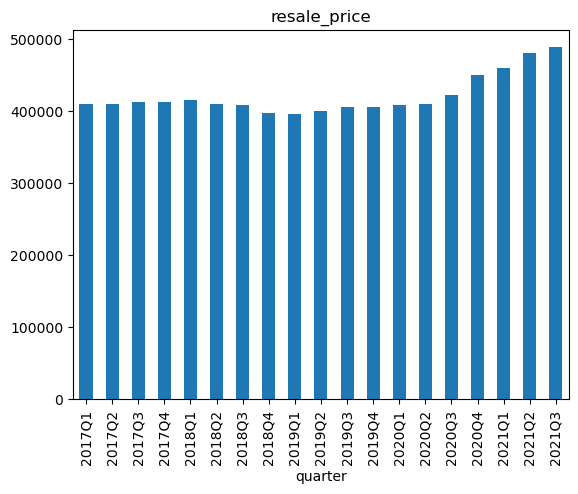

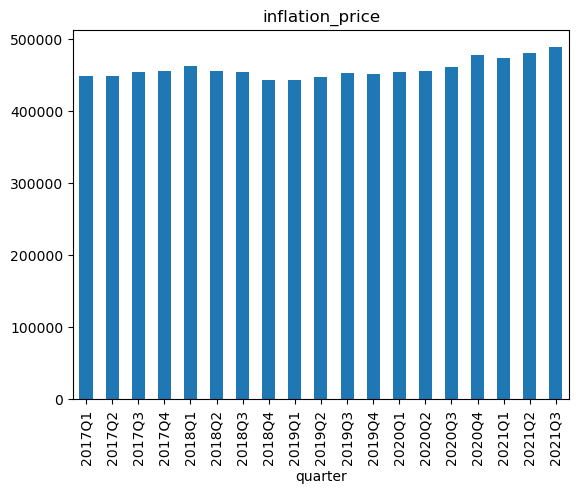

In [108]:
# Examining resale prices before and after adjustment

for feature in ('resale_price', 'inflation_price'):
    temp_df = price_df.copy()
    temp_df.groupby('quarter')[feature].median().plot.bar()
    plt.title(feature)
    plt.show()

In [98]:
# Merging adjusted prices back into the original dataset.

resale_df = pd.concat([resale_df, price_df['quarter'], price_df['inflation_price']], axis=1)

---

### Saving the dataset

At this stage, all the additional features mentioned above have been added to the dataset. The dataset can now be saved to a csv file for data analysis and model building.

In [99]:
# Checking dataset to ensure all columns are present.

resale_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,address,latitude,longitude,nearest_mrt,nearest_mrt_dist,nearest_pri_sch,nearest_pri_sch_dist,nearest_sec_sch,nearest_sec_sch_dist,nearest_mall,nearest_mall_dist,quarter,inflation_price
0,ANG MO KIO,2 ROOM,Improved,44,ANG MO KIO AVE 10,232000,2017-01,61 years 04 months,1979,10 TO 12,1,406,406 ANG MO KIO AVENUE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.000002,TOWNSVILLE PRIMARY SCHOOL,0.218124,DEYI SECONDARY SCHOOL,0.465777,AMK Hub,1.014089,2017Q1,253657.953698
1,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 4,250000,2017-01,60 years 07 months,1978,01 TO 03,2,108,108 ANG MO KIO AVENUE 4,1.370966,103.838202,MAYFLOWER MRT STATION,0.190030,ANG MO KIO PRIMARY SCHOOL,0.241601,MAYFLOWER SECONDARY SCHOOL,0.434455,Broadway Plaza,0.869109,2017Q1,273338.312175
2,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,262000,2017-01,62 years 05 months,1980,01 TO 03,3,602,602 ANG MO KIO AVENUE 5,1.380709,103.835368,LENTOR MRT STATION,0.532151,MAYFLOWER PRIMARY SCHOOL,0.506847,PRESBYTERIAN HIGH SCHOOL,0.789393,Broadway Plaza,1.525833,2017Q1,286458.551159
3,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,265000,2017-01,62 years 01 month,1980,04 TO 06,4,465,465 ANG MO KIO AVENUE 10,1.366201,103.857201,ANG MO KIO MRT STATION,0.945591,TECK GHEE PRIMARY SCHOOL,0.691887,DEYI SECONDARY SCHOOL,0.518707,myVillage At Serangoon Garden,0.894047,2017Q1,289738.610906
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,265000,2017-01,62 years 05 months,1980,01 TO 03,5,601,601 ANG MO KIO AVENUE 5,1.381041,103.835132,LENTOR MRT STATION,0.498418,MAYFLOWER PRIMARY SCHOOL,0.546442,PRESBYTERIAN HIGH SCHOOL,0.811047,Broadway Plaza,1.569570,2017Q1,289738.610906


In [25]:
# Save main dataset to csv

resale_df.to_csv('data\\resale_prices.csv', index=False)

In [ ]:
# Saving geocoded data to csv

coord_df.to_csv('data\\coord_data.csv', index=False)
mrt_dist_df.to_csv('data\\nearest_mrt.csv', index=False)
schools_pri_dist_df.to_csv('data\\nearest_pri_sch.csv', index=False)
schools_sec_dist_df.to_csv('data\\nearest_sec_sch.csv', index=False)
malls_dist_df.to_csv('data\\nearest_mall.csv', index=False)